In [1]:
import urllib2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
dataset = urllib2.urlopen('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv')
data = pd.read_csv(dataset)

In [3]:
data.head(n=20)


,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.625074
1,2,No,Yes,817.180407,12106.134700
2,3,No,No,1073.549164,31767.138947
3,4,No,No,529.250605,35704.493935
4,5,No,No,785.655883,38463.495879
5,6,No,Yes,919.588530,7491.558572
6,7,No,No,825.513331,24905.226578
7,8,No,Yes,808.667504,17600.451344
8,9,No,No,1161.057854,37468.529288
9,10,No,No,0.000000,29275.268293


2) Convert `default` and `student` to categorical variables.

In [4]:
def get_y(y):
    if y.find("No")>-1:
        return 0
    else:
        return 1

data_temp = data

data_temp['default'] = data_temp['default'].apply(lambda y: get_y(y))
data_temp['student'] = data_temp['student'].apply(lambda y: get_y(y))

In [5]:
data_final = data_temp
data_final = data_final.drop('Unnamed: 0',1)
data_final.head(n=20)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947
3,0,0,529.250605,35704.493935
4,0,0,785.655883,38463.495879
5,0,1,919.588530,7491.558572
6,0,0,825.513331,24905.226578
7,0,1,808.667504,17600.451344
8,0,0,1161.057854,37468.529288
9,0,0,0.000000,29275.268293


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

/Users/lingxiangyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


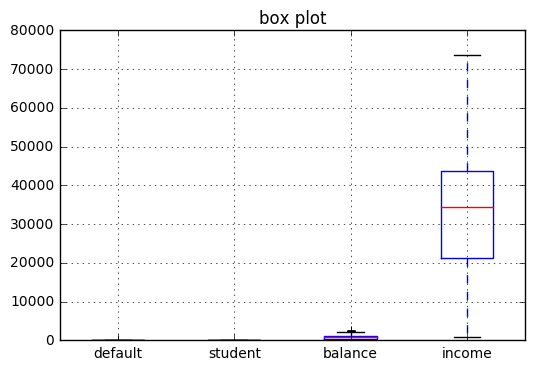

In [6]:
data_final.boxplot()
plt.title('box plot')
plt.show()

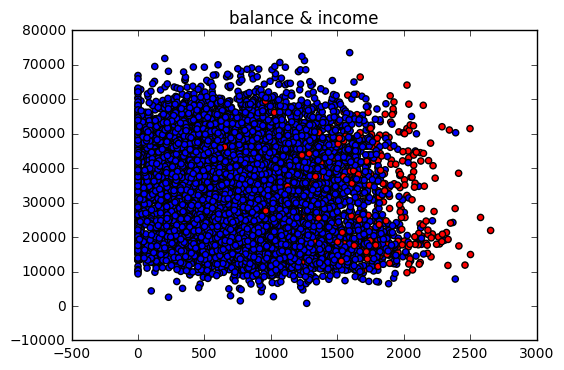

In [7]:
fig, ax = plt.subplots()
col = {0:'blue', 1:'red'}
ax.scatter(data_final.balance, data_final.income, c=data_final['default'].apply(lambda x: col[x]))
plt.title('balance & income')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [8]:
X1 = data_final[['balance','income']]
y1 = data_final[['default']]

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

n1_samples, n1_features = X1.shape

half = int(n1_samples/2)
X1_train, X1_test = X1[:half], X1[half:]
y1_train, y1_test = y1[:half], y1[half:]




In [88]:
regr1 = LogisticRegression()
model1 = regr1.fit(X1_train, y1_train)
probs = model1.predict_proba(X1_test)
#coeff1 = regr1.coef_
#inter1 = regr1.intercept_

#plt.contour(X1_test,y1_test,probs[:,1], levels=[0.5], vmin=9000, vmax=30000)
#plt.show()

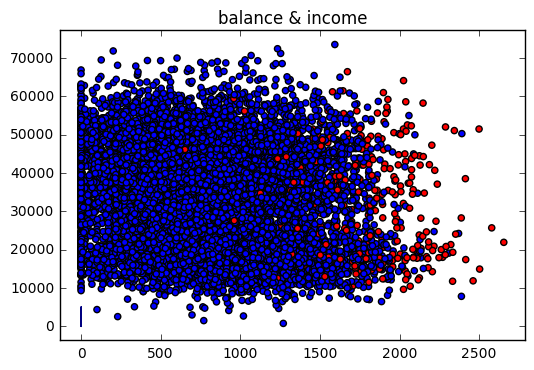

In [90]:
fig, ax = plt.subplots()
col = {0:'blue', 1:'red'}
ax.scatter(data_final.balance, data_final.income, c=data_final['default'].apply(lambda x: col[x]))
plt.title('balance & income')

#plt.plot(data_final.balance, data_final.balance*coeff1[0,1] + inter1[0], 'black')
ax.contour(X1_test,probs, levels=[0.5], color="green")
plt.show()

Area under the ROC curve : 0.500000
Area under the ROC curve : 0.500000
Area under the ROC curve : 0.500000
Area under the ROC curve : 0.500000
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959417
Area under the ROC curve : 0.959889
Area under the ROC curve : 0.960190
Area under the ROC curve : 0.960491
Area under the ROC curve : 0.960634
Area under the ROC curve : 0.960806
Area under the ROC curve : 0.960963
Area under the ROC curve : 0.961021
Area under the ROC curve : 0

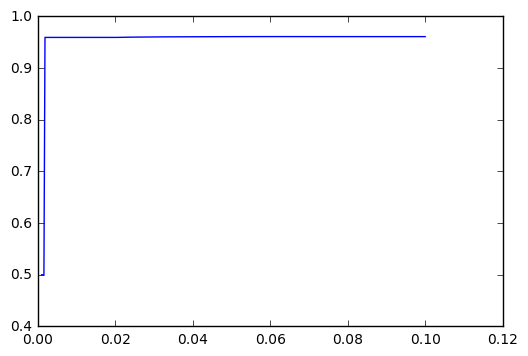

In [13]:
#compute AUC ROC
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds


alphas = np.logspace(-3,-1,30)
scores = []

for alpha in alphas:
    regr = LogisticRegression(C=alpha,penalty='l1')

    fpr, tpr, roc_auc, thresholds= generate_auc(X1,y1,LogisticRegression,C=alpha,penalty='l1')
    scores.append(roc_auc)

plt.plot(alphas,scores)
plt.show()

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [14]:
X2 = data_final[['balance','income','student']]
y2 = data_final[['default']]

scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

n2_samples, n2_features = X2.shape
half = int(n2_samples/2)
X2_train, X2_test = X2[:half], X2[half:]
y2_train, y2_test = y2[:half], y2[half:]

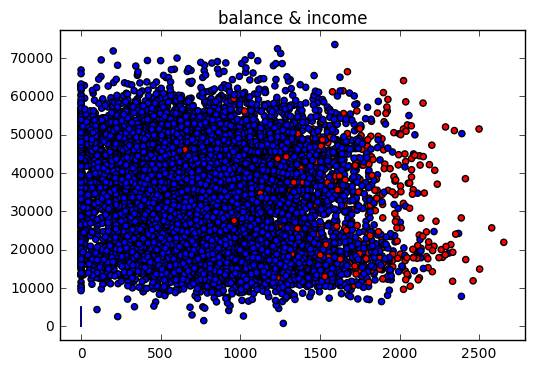

In [91]:
#decision boundary - LogisticRegression(penalty='l2') - Ridge
regr2 = LogisticRegression(penalty='l2')
model2 = regr2.fit(X2_train, y2_train)
probs = model2.predict_proba(X2_test)

fig, ax = plt.subplots()
col = {0:'blue', 1:'red'}
ax.scatter(data_final.balance, data_final.income, c=data_final['default'].apply(lambda x: col[x]))
plt.title('balance & income')

#plt.plot(data_final.balance, data_final.balance*coeff1[0,1] + inter1[0], 'black')
ax.contour(X2_test,probs, levels=[0.5], color="green",vmin=0, vmax=30000)
plt.show()

In [16]:
#Ridge Regression - doesnt work well so change to Lasso according to prof's email
# find the optimal alpha
alphas = np.logspace(-3,-1,30)
scoresR_test = []
scoresR_train = []
coeffR = []
for alpha in alphas:
    regrR = Lasso(alpha=alpha)
    regrR.fit(X2_train, y2_train)
    scoresR_test.append(regrR.score(X2_test,y2_test))
    scoresR_train.append(regrR.score(X2_train, y2_train))
    coeffR.append(regrR.fit(X2_train, y2_train).coef_)
    
best_alpha_Ridge_index = np.argmax(scoresR_test)
best_alpha_Ridge = alphas[best_alpha_Ridge_index]

#print "The optimazed alpha is ", 
best_alpha_Ridge

0.0035622478902624442

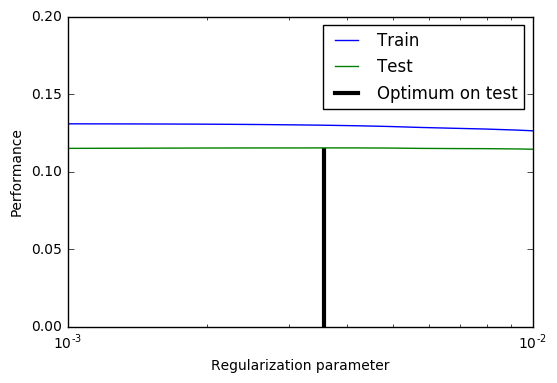

In [17]:
plt.semilogx(alphas, scoresR_train, label='Train')
plt.semilogx(alphas, scoresR_test, label='Test')
plt.vlines(best_alpha_Ridge, plt.ylim()[0], np.max(scoresR_test), color='k',linewidth=3, label='Optimum on test')
plt.legend(loc='upper right')
plt.ylim([0, 0.2])
plt.xlim([10^-3,0.01])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

plt.show()

In [18]:
# ranking of coeffs
coeffR = pd.DataFrame(coeffR)

X5 = data_final[['balance','income','student']]
coeffR_avg = []
coeffR_std = []
def get_coeffs(coeffs):
    coeffs_avgd = [sum(coeffs[:][i])/30 for i in range(0,3)]
    coeffs_std = [np.std([coeffs[:][i]]) for i in range(0,3)]
    return coeffs_avgd, coeffs_std
coeffR_avg,coeffR_std=get_coeffs(coeffR)

In [19]:
dfCoeffR = pd.DataFrame({'type':X5.columns.values, 'coef':coeffR_avg, 'std':coeffR_std})
dfCoeffR

,coef,std,type
0,0.045834,0.022278,balance
1,0.001366,0.001875,income
2,-0.000280,0.000554,student


/Users/lingxiangyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


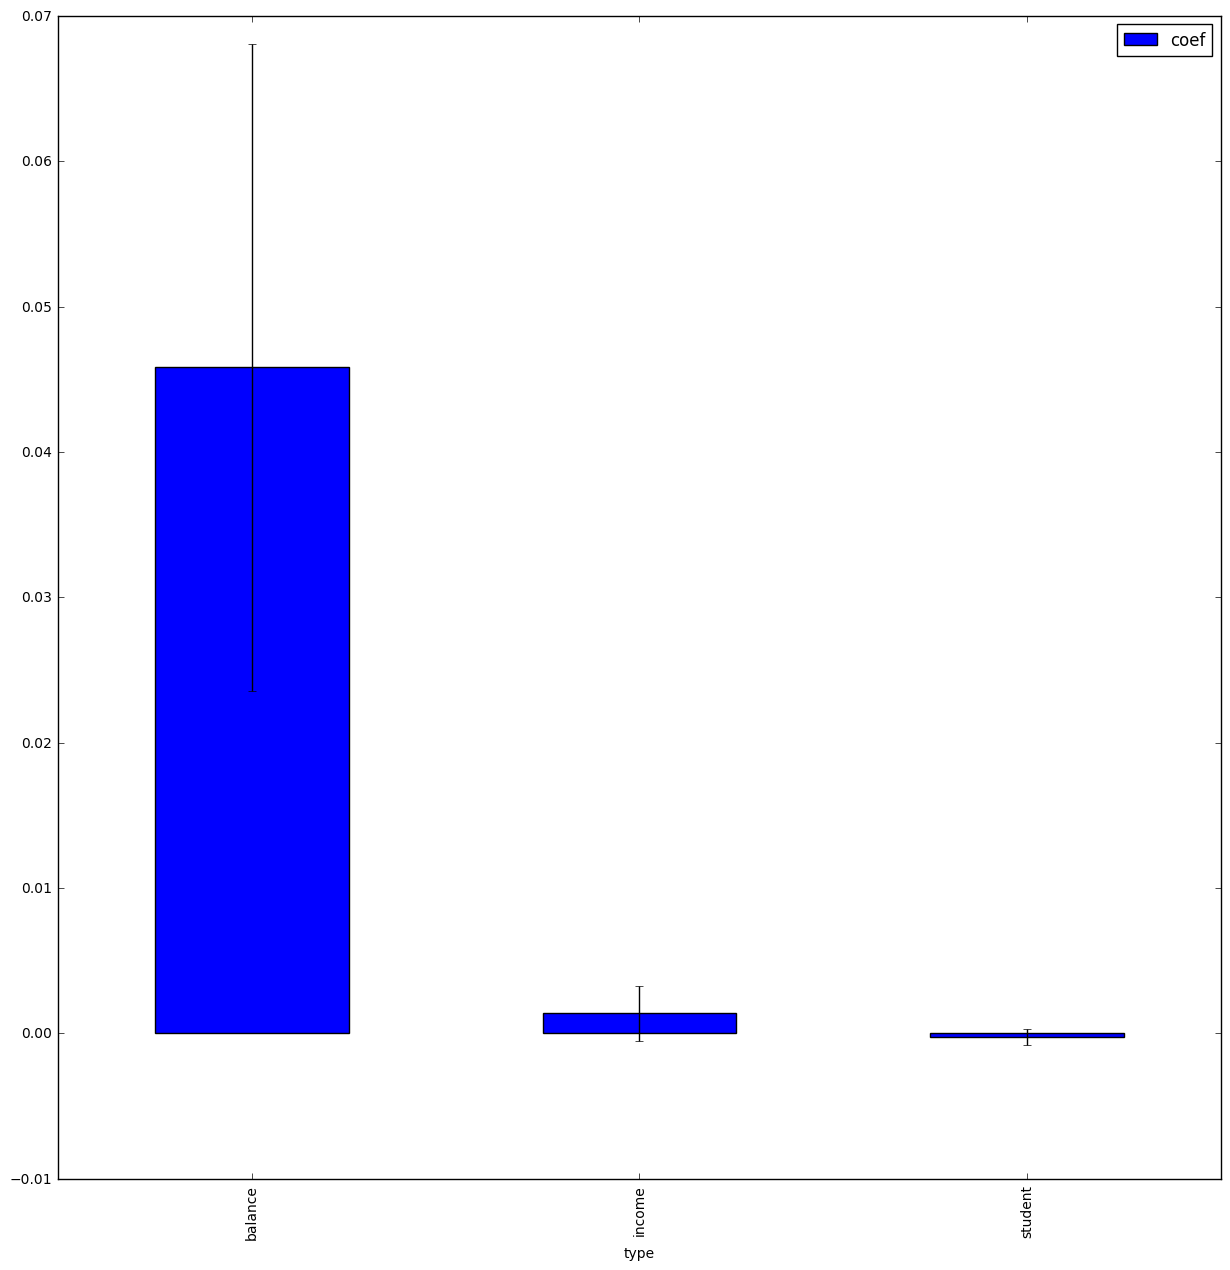

In [20]:
plt.figure(figsize=(15,15))
dfCoeffR_sorted = dfCoeffR.sort(['coef'])[::-1]
yerr_vals = dfCoeffR_sorted['std'].values
dfCoeffR_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [36]:
X4 = data_final[['balance','income','student']]
y4 = data_final[['default']]

In [51]:
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(n_splits=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
        y_train = y.loc[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        #y_pred[test_index] = clf.predict(X_test)
        #print clf.coef_[0]
        coeffs.append(clf.coef_)
    return coeffs

#scaler = preprocessing.StandardScaler()
#X4_scaled = X4.as_matrix().astype(np.float)
#X_scaled = scaler.fit_transform(X)
#X4_scaled2 = scaler.fit_transform(X4_scaled)


coeffsT = run_cv_coeffs(X4, y4, Lasso, alpha=best_alpha_Ridge)

In [73]:
coeffsT = pd.DataFrame(coeffsT)
coeffsT

,0,1,2
0,0.000131,3.802965e-07,-0.0
1,0.000135,4.910551e-07,-0.0
2,0.000128,5.673844e-07,-0.0
3,0.000138,4.134403e-07,-0.0
4,0.000128,4.504875e-07,-0.0


In [74]:
def get_coeffs(coeffs):
    coeffs_avgd = [sum(coeffs[:][i])/5 for i in range(0,3)]
    coeffs_std = [np.std([coeffs[:][i]]) for i in range(0,len(X4.columns))]
    return coeffs_avgd, coeffs_std
coeffsT_avg,coeffsT_std=get_coeffs(coeffsT)

In [75]:
dfCoeffsT = pd.DataFrame({'type':X4.columns.values, 'coef':coeffsT_avg, 'std':coeffsT_std})
dfCoeffsT

,coef,std,type
0,1.317642e-04,3.876291e-06,balance
1,4.605328e-07,6.496975e-08,income
2,0.000000e+00,0.000000e+00,student


/Users/lingxiangyu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


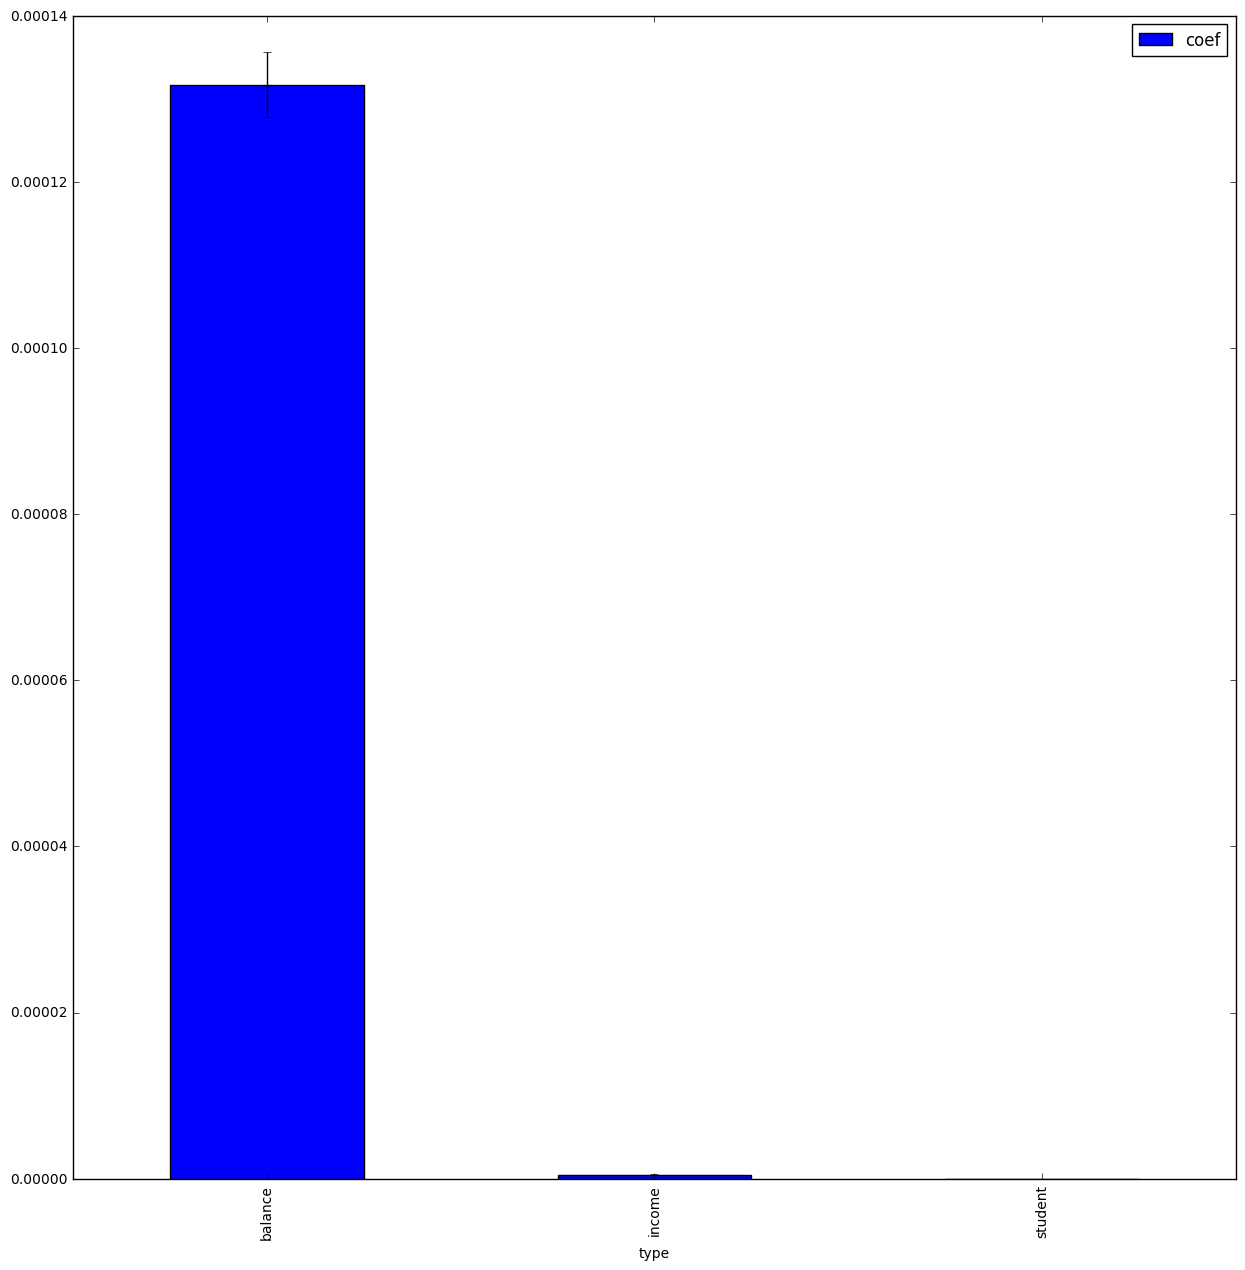

In [76]:
plt.figure(figsize=(15,15))

dfCoeffsT_sorted = dfCoeffsT.sort(['coef'])[::-1]
yerr_valsT = dfCoeffsT_sorted['std'].values

dfCoeffsT_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_valsT,figsize=(15,15))
plt.show()

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [78]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [79]:
regr3 = DecisionTreeRegressor(max_depth=5)
regr3.fit(X3_train,y3_train)
y3_pred = regr3.predict(X3_test)

In [ ]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [ ]:
from __future__ import print_function

import os
import subprocess

In [ ]:
visualize_tree(regr3, feature_names=['x'])

In [ ]:
from IPython.display import Image
dot_data=export_graphviz(regr3, out_file=None)
graph = Image.pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

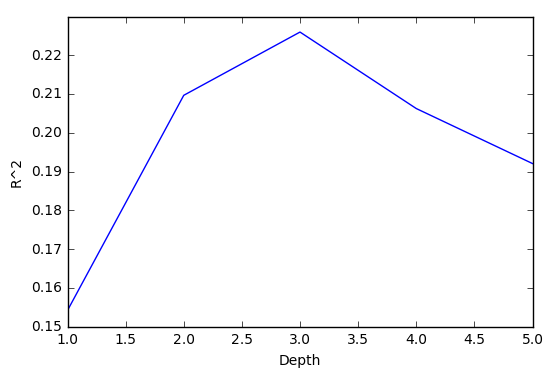

optimal decision tree depth 3


In [84]:
train_Tree_errors=[]
test_Tree_errors=[]
scores_Tree=[]
depths = range(1,6)
for n in depths:
    regr_Tree = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr_Tree.fit(X3_train, y3_train)
    train_Tree_errors.append(regr_Tree.score(X3_train,y3_train))
    scores_Tree.append(regr_Tree.score(X3_test,y3_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores_Tree)
test_Tree_errors=scores_Tree
n_opt=depths[np.argmax(scores_Tree)]
plt.show()
print 'optimal decision tree depth', n_opt

Area under the ROC curve : 0.638848
Area under the ROC curve : 0.626604
Area under the ROC curve : 0.638540
Area under the ROC curve : 0.637924
Area under the ROC curve : 0.650475
Area under the ROC curve : 0.626912
Area under the ROC curve : 0.650475
Area under the ROC curve : 0.637924
Area under the ROC curve : 0.660872
Area under the ROC curve : 0.638232
Area under the ROC curve : 0.637924
Area under the ROC curve : 0.649244
Area under the ROC curve : 0.637308
Area under the ROC curve : 0.649860
Area under the ROC curve : 0.649860
Area under the ROC curve : 0.638848
Area under the ROC curve : 0.638232
Area under the ROC curve : 0.637616
Area under the ROC curve : 0.638848
Area under the ROC curve : 0.650783
Area under the ROC curve : 0.650475
Area under the ROC curve : 0.638848
Area under the ROC curve : 0.637924
Area under the ROC curve : 0.638848
Area under the ROC curve : 0.637616
Area under the ROC curve : 0.638540
Area under the ROC curve : 0.637924
Area under the ROC curve : 0

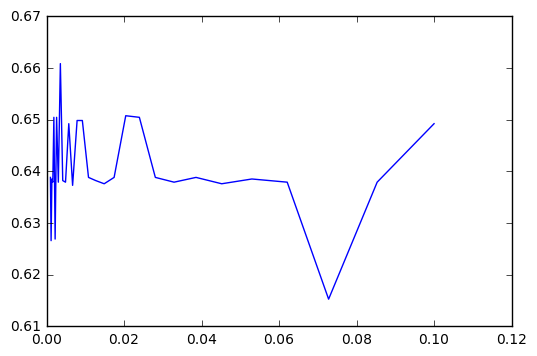

In [86]:
#compute AUC ROC
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    X, y = shuffle(X, y, random_state=random_state)
    n_samples, n_features = X.shape
    half = int(n_samples/1.2)
    X_train, X_test = X[:half], X[half:]
    y_train, y_test = y[:half], y[half:]
    
    classifier = clf_class(**kwargs)
    pred = classifier.fit(X_train, y_train).predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)
    print "Area under the ROC curve : %f" % roc_auc
    return fpr, tpr, roc_auc, thresholds


alphas = np.logspace(-3,-1,30)
scores_T = []

for alpha in alphas:
    regr_T = DecisionTreeRegressor(max_depth=n)

    fpr, tpr, roc_auc, thresholds= generate_auc(X2,y2,DecisionTreeRegressor)
    scores_T.append(roc_auc)

plt.plot(alphas,scores_T)
plt.show()